In [1]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
gc.enable()

In [18]:
df_core_snps = pd.read_csv("core_snps_filtered.csv", sep='\t')
df_core_snps.head(2)

,ref_rs_id,ref_chr,ref_bp,ref_af,ref_allele,ref_other_allele,ref_snp_num
0,rs7518469,1,4756276,0.94036,G,T,7518469
1,rs7521197,1,5758772,0.07654,C,T,7521197


In [3]:
df_eur = pd.read_csv("eur_tables/EUR_all_chr.ld", sep='\t')
df_british = pd.read_csv("eur_tables/British_all_chr.ld", sep='\t')
df_ceph = pd.read_csv("eur_tables/CEPH_all_chr.ld", sep='\t')
df_finnish = pd.read_csv("eur_tables/Finnish_all_chr.ld", sep='\t')
df_spanish = pd.read_csv("eur_tables/Spanish_all_chr.ld", sep='\t')
df_tuscan = pd.read_csv("eur_tables/Tuscan_all_chr.ld", sep='\t')
df_eur.head(2)

In [5]:
df_british.shape

(1088934, 9)

In [6]:
df_dict = {'bri':df_british, 'ceph':df_ceph, 'fin':df_finnish, 'spa':df_spanish, 'tus':df_tuscan}
size_dict = {'bri':91, 'ceph':99, 'fin':99, 'spa':107, 'tus':107}
for name, df in df_dict.items():
    df.drop(df[abs(df["R"])<0.3].index,inplace=True)

In [7]:
df_british.shape

(412390, 9)

In [8]:
merged_df = None
for name, df in df_dict.items():
    if merged_df is None:
        merged_df = df[['SNP_A', 'SNP_B', 'R']].copy()
        merged_df.rename(index=str, columns={"R": name}, inplace=True)
    else:
        df = df.rename(index=str, columns={"R": name}, inplace=False)
        merged_df = pd.merge(merged_df, df[['SNP_A', 'SNP_B', name]], how='inner', 
                       on=['SNP_A', 'SNP_B'])

In [21]:
print(merged_df.shape)
merged_df[['fin', 'spa', 'ceph', 'tus', 'bri']] = abs(merged_df[['fin', 'spa', 'ceph', 'tus', 'bri']])
#because I missed flag --keep-allele-order
merged_df.drop_duplicates(subset=['fin', 'spa', 'ceph', 'tus', 'bri'], inplace=True)
print(merged_df.shape)
merged_df['average'] = np.mean(merged_df[['fin', 'spa', 'ceph', 'tus', 'bri']], axis=1)
merged_df.head(2)

(110861, 8)
(110861, 8)


,SNP_A,SNP_B,bri,fin,spa,tus,ceph,average
0,rs7521197,rs77181634,0.867060,0.957095,0.865043,0.705167,0.924344,0.863742
1,rs7521197,rs34725366,0.575977,0.535802,0.529541,0.355696,0.507592,0.500922


In [111]:
def get_conf_interval(r, N=100, alpha=0.05):
    z = np.arctanh(r)
    SE = 1/np.sqrt(N-3)
    z_alpha_2 = abs(norm.ppf(alpha/2))
    lower_margin = np.tanh(z - SE * z_alpha_2)
    upper_margin = np.tanh(z + SE * z_alpha_2)
    return {"lower":lower_margin, "upper":upper_margin}

def get_conf_interval_for_diff(r1, r2, n1=200, n2=200, alpha=0.05):
    PE = r1 - r2
    SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
    z_alpha_2 = abs(norm.ppf(alpha/2))
    lower_margin = PE - SE * z_alpha_2
    upper_margin = PE + SE * z_alpha_2
    return {"lower":lower_margin, "upper":upper_margin}

def get_snp_pairs_in_range(lower_threshold, upper_threshold, nation):
    df_temp = merged_df[(abs(merged_df[nation]) > lower_threshold) & 
                        (abs(merged_df[nation]) < upper_threshold)].copy()
    df_temp.drop_duplicates(subset='SNP_A', inplace=True)
    return df_temp

def var_r(r, n):
    variance = (1-r**2)/(n-2)
    return variance

def get_margin_r_for_diff(r1, n1=200, n2=200, alpha=0.05):
    z_alpha_2 = abs(norm.ppf(alpha/2))
    for r2 in np.linspace(r1,1,1000):
        PE = r1 - r2
        SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
        upper_margin = PE + SE * z_alpha_2
        if upper_margin < 0:
            r2_upper = r2
            break
    for r2 in np.linspace(r1,0,1000):
        PE = r1 - r2
        SE = np.sqrt((1 - r1**2)**2/n1 + (1 - r2**2)**2/n2)
        lower_margin = PE - SE * z_alpha_2
        if lower_margin > 0:
            r2_lower = r2
            break
    return {"r2_lower":r2_lower, "r2_upper":r2_upper}

In [118]:
var_r(0.7, size_dict['spa']*2)

0.002405660377358491

In [114]:
initial_r = 0.7
initial_margin = 0.01

731


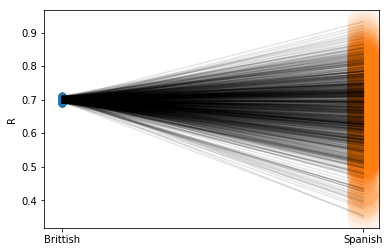

Variance 
 ceph       0.009334
spa        0.010285
average    0.004143
tus        0.011102
fin        0.014379
bri        0.000034
dtype: float64
mean 
 ceph       0.679263
spa        0.668863
average    0.678168
tus        0.664356
fin        0.678549
bri        0.699811
dtype: float64


In [117]:
df_temp = get_snp_pairs_in_range(initial_r - initial_margin , initial_r + initial_margin, nation='bri')
print(len(df_temp))

# plotting the points
plt.scatter(np.zeros(len(df_temp)), df_temp.bri, s=50, alpha=0.1)
plt.scatter(np.ones(len(df_temp)), df_temp.spa, s=1000, alpha=0.05)

# plotting the lines
for index, row in df_temp.iterrows():
    plt.plot( [0,1], [row.bri, row.spa], c='k', alpha=0.1)

plt.xticks([0,1], ['Brittish', 'Spanish'])
plt.ylabel('R')
plt.show()
print("Variance \n", df_temp[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']].var())
print("mean \n", df_temp[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']].mean())

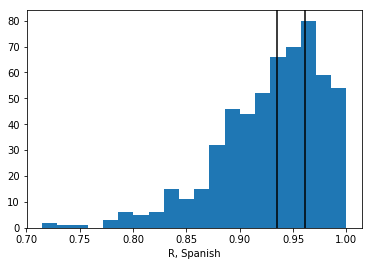

In [103]:
spanish_CI = get_conf_interval(initial_r, N=107*2)

plt.hist(df_temp.spa, bins=20)
plt.axvline(x=spanish_CI['lower'], c = 'k')
plt.axvline(x=spanish_CI['upper'], c = 'k')
plt.xlabel('R, Spanish')
plt.show()

In [104]:
print(spanish_CI)

{'upper': 0.96159858123359354, 'lower': 0.93501429533569969}


In [105]:
print('Percentage of SNP pairs inside CI')
print(sum((df_temp.spa > spanish_CI['lower']) & (df_temp.spa < spanish_CI['upper']) )/len(df_temp)*100)

Percentage of SNP pairs inside CI
24.2957746479


In [106]:
res = get_conf_interval_for_diff(df_temp.bri, df_temp.spa, n1=size_dict['bri']*2, n2=size_dict['spa']*2)
print(sum(res['lower']>0)/len(df_temp)*100)
print(sum(res['upper']<0)/len(df_temp)*100)
print(sum(res['lower']>0)/len(df_temp)*100 + sum(res['upper']<0)/len(df_temp)*100)

40.8450704225
24.4718309859
65.3169014085


In [108]:
delta_margin = get_margin_r_for_diff(initial_r, n1=size_dict['bri']*2, n2=size_dict['spa']*2, alpha=0.05)
print(delta_margin)
print(sum((df_temp.spa > delta_margin['r2_lower']) & (df_temp.spa < delta_margin['r2_upper']) )/len(df_temp.spa)*100)

{'r2_upper': 0.96671671671671666, 'r2_lower': 0.92622622622622619}
36.0915492958


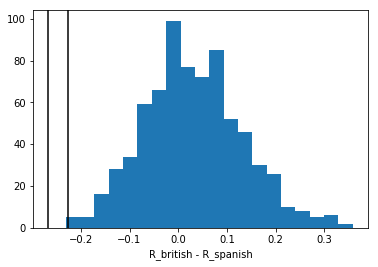

In [119]:
plt.hist(df_temp.bri - df_temp.spa , bins=20)
plt.xlabel('R_british - R_spanish')
plt.axvline(x=initial_r - delta_margin['r2_upper'], c = 'k')
plt.axvline(x=initial_r - delta_margin['r2_lower'], c = 'k')
plt.show()

# Delta-R from R


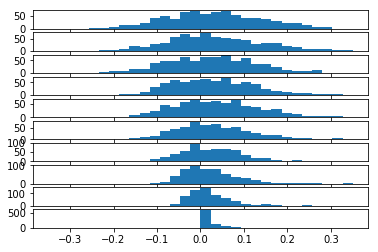

In [166]:
number_of_plots = 10
real_pop = 'bri'
reference = 'spa'
r_array = []
var_array = []
for index, initial_r in enumerate(np.linspace(0.6,1,number_of_plots)):
    df_temp = get_snp_pairs_in_range(initial_r - initial_margin , initial_r + initial_margin, nation=real_pop)
    plt.subplot(number_of_plots, 1, index+1)
    delta_r = df_temp[real_pop] - df_temp[reference]
    plt.hist(delta_r, bins=30,  range=(-0.35, 0.35))
    r_array.append(initial_r)
    var_array.append(delta_r.var())

plt.show()
    
    

In [170]:
delta_r.var()

0.00067052242805887264

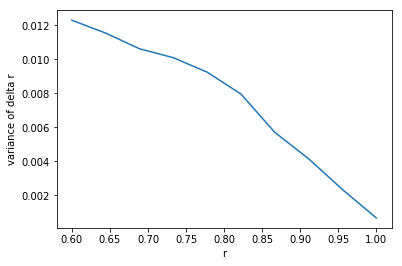

In [167]:
plt.plot(r_array, var_array)
plt.xlabel('r')
plt.ylabel('variance of delta r')
plt.show()

# Stuff

In [15]:
df_eur['dist'] = abs(df_eur['BP_A'] - df_eur['BP_B'])

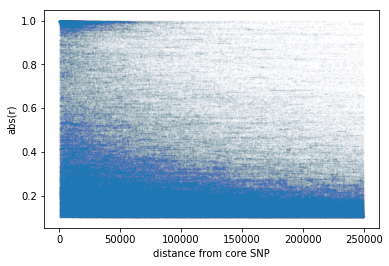

In [16]:
plt.scatter(df_eur['dist'], abs(df_eur['R']), alpha=0.01, s=0.7)
plt.xlabel("distance from core SNP")
plt.ylabel("abs(r)")
plt.show()

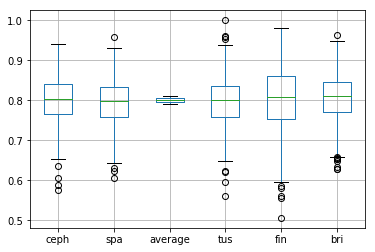

ceph       0.057434
spa        0.057922
average    0.005912
tus        0.060249
fin        0.077822
bri        0.056592
dtype: float64


In [23]:
df_08 = get_snp_pairs_in_range(lower_threshold=0.79, upper_threshold=0.81)
abs(df_08[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).boxplot()
plt.show()
print(abs(df_08[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).std())

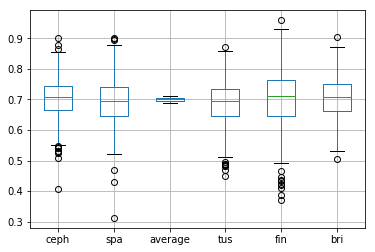

ceph       0.063839
spa        0.071309
average    0.006055
tus        0.070032
fin        0.092296
bri        0.068226
dtype: float64


In [24]:
df_07 = get_snp_pairs_in_range(lower_threshold=0.69, upper_threshold=0.71)
abs(df_07[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).boxplot()
plt.show()
print(abs(df_07[['ceph', 'spa', 'average', 'tus', 'fin', 'bri']]).std())

# Fisher Z-transformation

In [70]:
get_conf_interval(0.7, N=91*2)

{'lower': 0.61740827327609737, 'upper': 0.76732715371743243}

In [72]:
get_conf_interval(0.7, N=107*2)

{'lower': 0.62451378613348041, 'upper': 0.76252911469958629}

In [39]:
ci = get_conf_interval(0.8, N=100)
print(ci)
for name in df_dict.keys():
    print( name, len(df_08[(abs(df_08[name]) > ci["lower"]) & (abs(df_08[name]) < ci["upper"])])/len(df_08))

{'lower': 0.71610699230849739, 'upper': 0.86110830048131048}
fin 0.6783216783216783
ceph 0.8041958041958042
eur 1.0
tus 0.7832167832167832
bri 0.7272727272727273
spa 0.7832167832167832
